## Model Comparison & Evaluation Notebook

This notebook compares the prediction outputs from multiple models against a standard reference.

The evaluation workflow includes:
1. Loading prediction outputs from all models and the standard reference 
2. Computing the mean contour with error bands based on the number of user labels
4. Comparing model outputs against the standard reference
5. Visualising results in polar coordinate plots and in the test-images
6. Calculating Intersection over Union (IoU) metrics




In [1]:
from ultralytics import YOLO
import general_functions as gf
from matplotlib import pyplot as plt
import distribution_center as dc
import glob
import radial_comparison as rc
import area_comparison as ac
import numpy as np
import shapely
import multiprocessing
import cv2
from shapely.geometry import Polygon
from matplotlib.lines import Line2D
import os

# Jupyter Lab Configuration for Contour Analysis

## Path Variables

The following path variables need to be set for processing and comparing contour detection results:

## Description of Paths

- **`img_path`**: Contains images where contours have been detected using different algorithms.
- **`file_path`**: Contains text files storing standard reference contours for comparison. These files follow the YOLO format and must contain only one contour per file.
- **`compare_path_yolo`**: Stores YOLO-detected contour text files. These files follow the YOLO format and contain only one contour per file.
- **`compare_path_algo`**: Stores contour text files detected by the algorithm (MO). These files are formatted in YOLO format and must contain only one contour per file.
- **`compare_path_users`**: Stores user-labelled contour text files for each image in `img_path`. The file names must match the corresponding image name with the suffix `_user_No`, where `No` represents the user number.
- **`savepath`**: Stores results.

## Notes
- Ensure that each text file follows the YOLO format.
- Only one contour per file is allowed.
- User-labelled contour files must be named correctly to match the corresponding image.
- Paths must be correctly assigned before running any contour comparison or evaluation scripts.

In [2]:
img_path = '.../test_images'
file_path ='.../outputs/standard_reference/surface_damage'
compare_path_yolo = '.../outputs/yolov8seg/surface_damage'
compare_path_algo = '.../outputs/MOSES_Impacts'
compare_path_users = '.../outputs/UserLabels/surface_damage'
savepath = '.../outputs/evaluation/surface_damage/polar_plots'

# User Variables

- Number of angles for the radial intersection point calculation.

- angle_steps = 720 means 0.5 degree steps

- Point size and linewidth for plots with pyplot

- Number of processor cores with which the evaluation can be calculated

In [4]:
angle_steps = 720
point_size = 0.4
linewidth = 0.15
processor_cores=4

# Center calculation

- read images

In [5]:
image_paths = glob.glob(img_path + '/*')
image_paths.sort()
images = [cv2.imread(path) for path in image_paths]

im=images[0]
image_height, image_width, image_channels = im.shape

- Sum of color channels for each pixel to get a value for an 2D gaussian fit.


In [6]:
pool = multiprocessing.Pool(processes=processor_cores)
args = [(sum, 2, image) for image in images]
sum_grayscales = pool.starmap(np.apply_along_axis, args)

- Calculate the centers with a 2D gaussian function.  
This option allows to get a mask independen center point.
That point will be used for mask comparisions.  
**note:** This could take some time. Use multiprocessing to speed it up.

In [7]:
pool = multiprocessing.Pool(processes=processor_cores)
args = [([img], [['gauss', [0.5, 0.02, False, False]]]) for img in sum_grayscales]
centers = pool.starmap(dc.get_centers, args)
print(centers[0][0])

(22.928148195862438, 22.663085653327396)


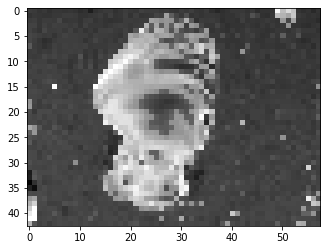

In [8]:
img=images[0]
plt.imshow(img)

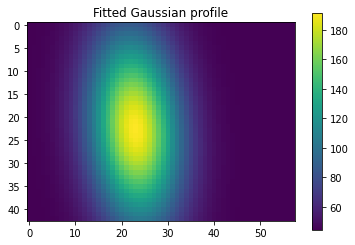

In [9]:
img_gray = img.mean(axis=2)  # Mittelwert über R, G, B → (43, 58)
height, width = img_gray.shape
popt_g, pcov_g, gauss_fit_g = dc.get_gauss_in_image(img_gray,0.5, 0.02, False, False)

def gaussian_2D(coord, xo, yo, sigma_x, sigma_y, offset, amplitude, rotation_angle):
    x, y = coord
    a = (np.cos(rotation_angle)**2)/(2*sigma_x**2) + (np.sin(rotation_angle)**2)/(2*sigma_y**2)
    b = -(np.sin(2*rotation_angle))/(4*sigma_x**2) + (np.sin(2*rotation_angle))/(4*sigma_y**2)
    c = (np.sin(rotation_angle)**2)/(2*sigma_x**2) + (np.cos(rotation_angle)**2)/(2*sigma_y**2)
    g = offset + amplitude * np.exp(
        - (a*((x - xo)**2) + 2*b*(x - xo)*(y - yo) + c*((y - yo)**2))
    )
    return g.ravel()

# 1. Create a coordinate grid
x = np.linspace(0, width, width, endpoint=False)
y = np.linspace(0, height, height, endpoint=False)
x, y = np.meshgrid(x, y)

# 2. Calculate Gaussian function from fit parameters
gauss_fit2 = gaussian_2D((x, y), *popt_g).reshape(img_gray.shape)

plt.imshow(gauss_fit2, cmap='viridis')
plt.title("Fitted Gaussian profile")
plt.colorbar()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


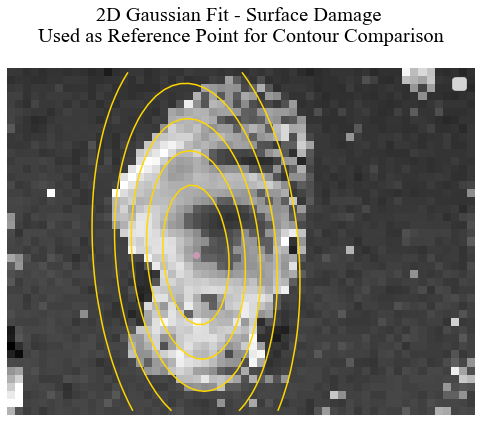

In [11]:
# Set font globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 17

# Image display with Gaussian contours
plt.figure(figsize=(7, 6))
plt.imshow(img_gray, cmap='gray')

# Contour colours as a surface (ensures continuous colour bars)
contour_levels = np.linspace(gauss_fit2.min(), gauss_fit2.max(), 7)
contourf= plt.contour(x, y, gauss_fit2, levels=contour_levels, colors='gold', linewidths=1.5)

# Mark the centre of the Gaussian fit
xo, yo = popt_g[0], popt_g[1]
plt.plot(xo, yo, color=[0.8, 0.6, 0.7], marker='o')

# Title and legend
plt.title("2D Gaussian Fit - Surface Damage \n Used as Reference Point for Contour Comparison \n")
plt.legend()
plt.axis('off')
plt.tight_layout()

#plt.savefig(savepath+"gaussian_fit_plot.png", dpi=300, facecolor='white')  # Dateiname, Auflösung

plt.show()

# Radial Intersection Points

- Read masks from Users .txt files.
- Read masks from YOLO .txt files.
- Read masks from Algo .txt files. 
- Read masks from Standardreference .txt files.

The masks will be read to seperated lists, one list per image. 

**note:**  
Here we only read one mask per file.  
If you have multiple masks in one txt, decide for one.  
The read function could read multi-mask txt files, but for the comparison, it is necessary to have one mask per txt.

In [12]:
all_compare_masks_users = []
all_compare_masks_yolo = []
all_compare_masks_algo = []
all_standardreference_masks = [] 

for image_path in image_paths:

    name = image_path.replace('\\', '/').split('/')[-1].split('.')[-2]
    compare_masks_paths_users = glob.glob(compare_path_users + '/' + name + '_User_*' + '.txt')
    compare_masks_paths_users = [path.replace('\\', '/') for path in compare_masks_paths_users]
    compare_masks_paths_users.sort()
    compare_masks_paths_yolo = glob.glob(compare_path_yolo + '/' + name + '_*' + '.txt')
    compare_masks_paths_yolo.sort()
    compare_masks_paths_algo = glob.glob(compare_path_algo + '/' + name + '_*' + '.txt') 
    compare_masks_paths_algo.sort()
    standardreference_paths = glob.glob(file_path + '/' + name +'.txt')
    standardreference_paths.sort()

    all_compare_masks_users.append(gf.read_masks_from_txt(compare_masks_paths_users)[1])
    all_compare_masks_yolo.append(gf.read_masks_from_txt(compare_masks_paths_yolo)[1])
    all_compare_masks_algo.append(gf.read_masks_from_txt(compare_masks_paths_algo)[1])  
    all_standardreference_masks.append(gf.read_masks_from_txt(standardreference_paths)[1])

- Convert mask to shapley polygons

In [13]:
compare_polygons_user = [gf.polygons_from_coordinates([mask[0] if mask != [] else mask for mask in masks])[0] for masks in all_compare_masks_users]
compare_polygons_yolo = [gf.polygons_from_coordinates([mask[0] if mask != [] else mask for mask in masks])[0] for masks in all_compare_masks_yolo]
compare_polygons_algo = [gf.polygons_from_coordinates([mask[0] if mask != [] else mask for mask in masks])[0] for masks in all_compare_masks_algo]
standardreference_polygons = [gf.polygons_from_coordinates([mask[0] if mask != [] else mask for mask in masks])[0] for masks in all_standardreference_masks]

- Setup angles (angles)
- Get all calculactes Center Points in relative coordinates (rel_centers)

In [14]:
angles = [2*np.pi*(1/angle_steps)*(i) for i in range(0, angle_steps)]
rel_centers = [(centers[i][0][0]/images[i].shape[1], centers[i][0][1]/images[i].shape[0]) for i in range(0, len(centers))]

- Calculate all radii with polygon-line intersections
- To do that, convert the center points to relative coordinates first

In [15]:
all_compare_polygons_user_intersections = []
all_compare_polygons_yolo_intersections = []
all_compare_polygons_algo_intersections = []
all_standardreference_polygons_intersections = []

for i in range(0, len(standardreference_polygons)):
    lines = [rc.line_at_angle(rel_centers[i], angle) for angle in angles]
    compare_intersections_users = []
    compare_intersections_yolo = []
    compare_intersections_algo = []
    standardreference_intersections = []
    for polygon in compare_polygons_user[i]:
        intersections = shapely.intersection(lines, polygon)
        compare_intersections_users.append((polygon, intersections))
    for polygon in compare_polygons_yolo[i]:
        intersections = shapely.intersection(lines, polygon)
        compare_intersections_yolo.append((polygon, intersections))
    for polygon in compare_polygons_algo[i]:
        intersections = shapely.intersection(lines, polygon)
        compare_intersections_algo.append((polygon, intersections))
    for polygon in standardreference_polygons[i]:
        intersections = shapely.intersection(lines, polygon)
        standardreference_intersections.append((polygon, intersections))
    all_compare_polygons_user_intersections.append(compare_intersections_users)
    all_compare_polygons_yolo_intersections.append(compare_intersections_yolo)
    all_compare_polygons_algo_intersections.append(compare_intersections_algo)
    all_standardreference_polygons_intersections.append(standardreference_intersections)

In [16]:
all_compare_radii_users = []
all_compare_radii_yolo = []
all_compare_radii_algo = []
all_standardreference_radii = []

for i in range(0, len(all_standardreference_polygons_intersections)):
    all_compare_radii_users.append(rc.intersection_radii(all_compare_polygons_user_intersections[i], rel_centers[i]))
    all_compare_radii_yolo.append(rc.intersection_radii(all_compare_polygons_yolo_intersections[i], rel_centers[i]))
    all_compare_radii_algo.append(rc.intersection_radii(all_compare_polygons_algo_intersections[i], rel_centers[i]))
    all_standardreference_radii.append(rc.intersection_radii(all_standardreference_polygons_intersections[i], rel_centers[i]))

# Calculated User Mean Mask and Uncertainty-Band

- Get mean and standard deviation from radii with mean_radii_at_angle. Do that for all masks and all angles in one mask.

**note**: You might get Warnings for empty slices in combination with invalid value in scaler divide. 
This could happen if there are masks that do not have intersection points, but the function should still work.


In [17]:
all_mean_mask_points = []
for radii in all_compare_radii_users:
    mean_mask_points = []
    for a in range(0, len(angles)):
        mean_mask_points.append(rc.mean_radii_at_angle([mask_radii[a] for mask_radii in radii]))
    all_mean_mask_points.append(mean_mask_points)

- Construct the uncertainty band.

In [18]:
bands = []
for mean_mask in all_mean_mask_points:
    bands.append(rc.mean_mask_uncertainty(mean_mask))

# Plot and Save: All Contours in Images

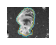

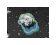

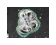

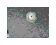

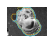

In [19]:
all_mean_masks_pxcoord = []  #List for storing the mean_mask coordinates of all images

for i in range(0,len(image_paths)):
   
    name = image_paths[i].replace('\\', '/').split('/')[-1].split('.')[-2]
    #Set the plot size according to the image size
    fig, ax = plt.subplots(figsize=(images[i].shape[1] / 100, images[i].shape[0] / 100))
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY), cmap='gray')
    #Draw the centre point as a red dot
    ax.scatter([centers[i][0][0]], [centers[i][0][1]], color=[0.8, 0.6, 0.7], s=point_size+0.4, edgecolors='black', linewidth=0.1+0.1) 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    #Calculate the contours.
    o = 0
    ang_parts, ri_min, ra_min = rc.plot_coordinates_of_nth_intersections(0, bands[i][0], angles)
    ang_parts, ri_mean, ra_mean = rc.plot_coordinates_of_nth_intersections(0, bands[i][1], angles)
    ang_parts, ri_max, ra_max = rc.plot_coordinates_of_nth_intersections(0, bands[i][2], angles)
    image_uncertainty_polygons = []
    while sum([len(l) for l in ang_parts]) != 0:
        for p in range(0, len(ang_parts)):
            #lower uncertainty bands for both points of one intersection segment
            cartesian_coords_min_i = gf.cartesian_coordiantes((ang_parts[p] + ang_parts[p][::-1],
                                                               ri_min[p] + ri_mean[p][::-1]),
                                                              center = rel_centers[i], size = images[i].shape[1::-1])
            cartesian_coords_min_a = gf.cartesian_coordiantes((ang_parts[p] + ang_parts[p][::-1],
                                                               ra_min[p] + ra_mean[p][::-1]),
                                                              center = rel_centers[i], size = images[i].shape[1::-1])
            ax.fill(cartesian_coords_min_i[0], cartesian_coords_min_i[1], c = [0.35,0.7,0.9,0.6], linewidth = 0)
            ax.fill(cartesian_coords_min_a[0], cartesian_coords_min_a[1], c = [0.53,0.7,0.9,0.6], linewidth = 0)
            image_uncertainty_polygons.extend([shapely.Polygon([(cartesian_coords_min_i[0][i], cartesian_coords_min_i[1][i]) for i in range(0, len(cartesian_coords_min_i[0]))]),
                                               shapely.Polygon([(cartesian_coords_min_a[0][i], cartesian_coords_min_a[1][i]) for i in range(0, len(cartesian_coords_min_a[0]))])])

            #upper uncertainty bands for both points of one intersection segment
            cartesian_coords_max_i = gf.cartesian_coordiantes((ang_parts[p] + ang_parts[p][::-1],
                                                               ri_max[p] + ri_mean[p][::-1]),
                                                              center = rel_centers[i], size = images[i].shape[1::-1])
            cartesian_coords_max_a = gf.cartesian_coordiantes((ang_parts[p] + ang_parts[p][::-1],
                                                               ra_max[p] + ra_mean[p][::-1]),
                                                              center = rel_centers[i], size = images[i].shape[1::-1])

            ax.fill(cartesian_coords_max_i[0], cartesian_coords_max_i[1], c = [0.35,0.7,0.9,0.6],  linewidth = 0)
            ax.fill(cartesian_coords_max_a[0], cartesian_coords_max_a[1], c = [0.35,0.7,0.9,0.6], linewidth = 0)

            image_uncertainty_polygons.extend([shapely.Polygon([(cartesian_coords_max_i[0][i], cartesian_coords_max_i[1][i]) for i in range(0, len(cartesian_coords_max_i[0]))]),
                                               shapely.Polygon([(cartesian_coords_max_a[0][i], cartesian_coords_max_a[1][i]) for i in range(0, len(cartesian_coords_max_a[0]))])])

            #mean masks for both points of one intersection segment
            cartesian_coords_mean_i = gf.cartesian_coordiantes((ang_parts[p], ri_mean[p]),
                                                               center = rel_centers[i], size = images[i].shape[1::-1])
            cartesian_coords_mean_a = gf.cartesian_coordiantes((ang_parts[p], ra_mean[p]),
                                                               center = rel_centers[i], size = images[i].shape[1::-1])
            ax.plot(cartesian_coords_mean_i[0], cartesian_coords_mean_i[1], c = [0.35,0.7,0.9], linewidth=linewidth+0.15)
            ax.plot(cartesian_coords_mean_a[0], cartesian_coords_mean_a[1], c = [0.35,0.7,0.9], linewidth=linewidth)

            # Save the mean mask coordinates for each image
            mean_mask_pxcoords = {'image_name': name,'mean': list(zip(cartesian_coords_mean_i[0], cartesian_coords_mean_i[1]))}
            all_mean_masks_pxcoord.append(mean_mask_pxcoords)
        
        o = o + 1
        ang_parts, ri_min, ra_min = rc.plot_coordinates_of_nth_intersections(o, bands[i][0], angles)
        ang_parts, ri_mean, ra_mean = rc.plot_coordinates_of_nth_intersections(o, bands[i][1], angles)
        ang_parts, ri_max, ra_max = rc.plot_coordinates_of_nth_intersections(o, bands[i][2], angles)

    #masks to compare

    for mask in all_compare_masks_yolo[i]:
        ax.fill([point[0] * images[i].shape[1] for point in mask[0]],
                [point[1] * images[i].shape[0] for point in mask[0]],
                fill=False, color=[0.8, 0.4, 0], linewidth=linewidth+0.15)
    for mask in all_compare_masks_algo[i]:
        ax.fill([point[0] * images[i].shape[1] for point in mask[0]],
                [point[1] * images[i].shape[0] for point in mask[0]],
                fill=False, color=[0, 0.6, 0.5], linewidth=linewidth+0.15)
    for mask in all_standardreference_masks[i]:
        ax.fill([point[0] * images[i].shape[1] for point in mask[0]],
                [point[1] * images[i].shape[0] for point in mask[0]],
                fill=False, color=[0.95,0.9,0.25], linewidth=linewidth+0.15)

    #save image without white space
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.savefig(f"{savepath}/{name}_contours.png", dpi=2000, facecolor='white',transparent=False)
    #plt.close(fig)

# Save user_mean contour in pxl-txt and yolo-form-txt

In [21]:
# Export the user MEAN mask contour points to a txt file, once in pixel coordinates and once in YOLO format.


for mask_data in all_mean_masks_pxcoord[0:5]:
    image_name = mask_data['image_name']
    coords = mask_data['mean']

    if not coords:
        continue

    # Round to full pixel values
    rounded_coords = [(int(round(x)), int(round(y))) for x, y in coords]

    # Remove duplicates, keep order
    unique_coords = list(dict.fromkeys(rounded_coords))

    # Close contour: append first coordinate to the end
    if len(unique_coords) > 1:
        unique_coords.append(unique_coords[0])

    # Save original (pixel values)   
    coord_lines = [f"{x} {y}" for x, y in unique_coords]
    coord_text = "\n".join(coord_lines)
    
    txt_path = os.path.join(savepath,f"{image_name}_mean_user_contour_pxl_Koordinaten.txt") 
    

    with open(txt_path, "w") as f:
        f.write(coord_text)

    
    # Save pixel values in YOLO format
    normalized_coords = []
    for x, y in unique_coords:
        x_norm = x / image_width
        y_norm = y / image_height
        normalized_coords.extend([f"{x_norm:.6f}", f"{y_norm:.6f}"])

    yolo_line = "0 " + " ".join(normalized_coords)

    yolo_txt_path = os.path.join(savepath, f"{image_name}_mean_user_contour_yolo_Koordinaten.txt")
    with open(yolo_txt_path, "w") as f:
        f.write(yolo_line)

# RADIAL COMPARISON:
## standardreference mask with: yolo - MOSES-Impacts - user mean  


Mean deviations and std per image:
Image 0:
  MOSES         : 93.9098 % std: 8.9931 %
  YOLO          : 90.2330 % std: 9.8564 %
  User Mean     : 91.7572 % std: 5.9098 %
Image 1:
  MOSES         : 86.4997 % std: 18.2334 %
  YOLO          : 94.1043 % std: 5.0348 %
  User Mean     : 94.7844 % std: 3.8547 %
Image 2:
  MOSES         : 96.3625 % std: 4.7650 %
  YOLO          : 95.8823 % std: 3.0610 %
  User Mean     : 95.7099 % std: 2.6309 %
Image 3:
  MOSES         : 61.9048 % std: 38.0276 %
  YOLO          : 78.1590 % std: 13.4174 %
  User Mean     : 87.0960 % std: 7.3963 %
Image 4:
  MOSES         : 93.7986 % std: 11.4103 %
  YOLO          : 94.5392 % std: 4.8156 %
  User Mean     : 90.7660 % std: 10.0110 %

Overall mean deviations:
MOSES         : 86.4951 % std: 23.7600 %
YOLO          : 90.58 % std: 10.4470 %
User Mean     : 92.0227 % std: 7.1941 %


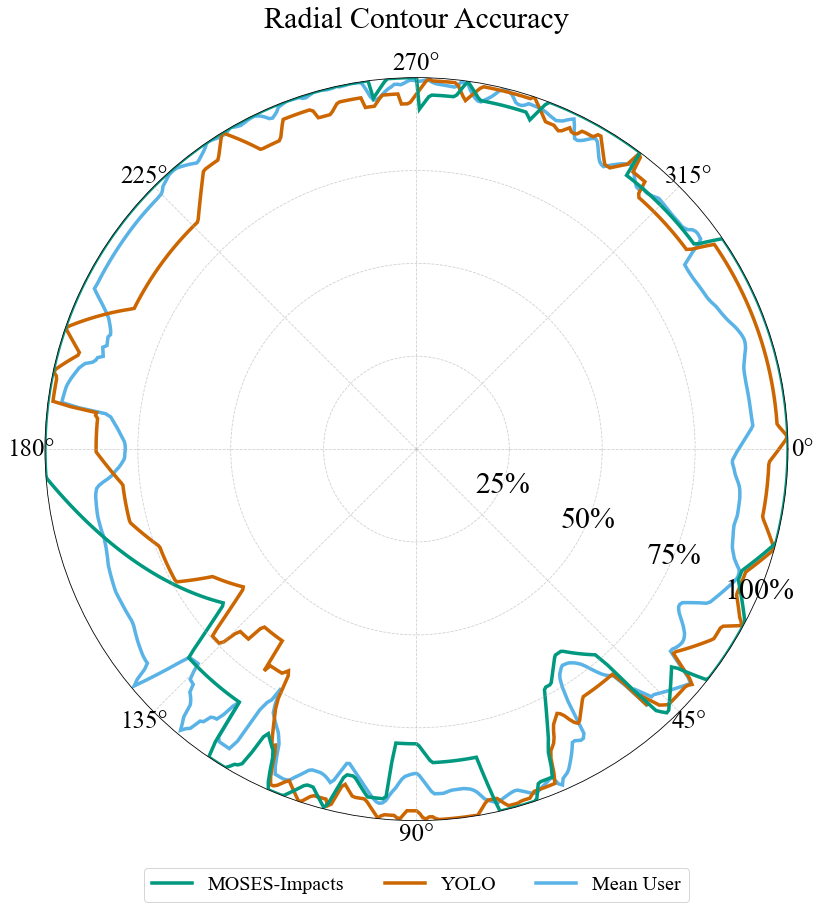

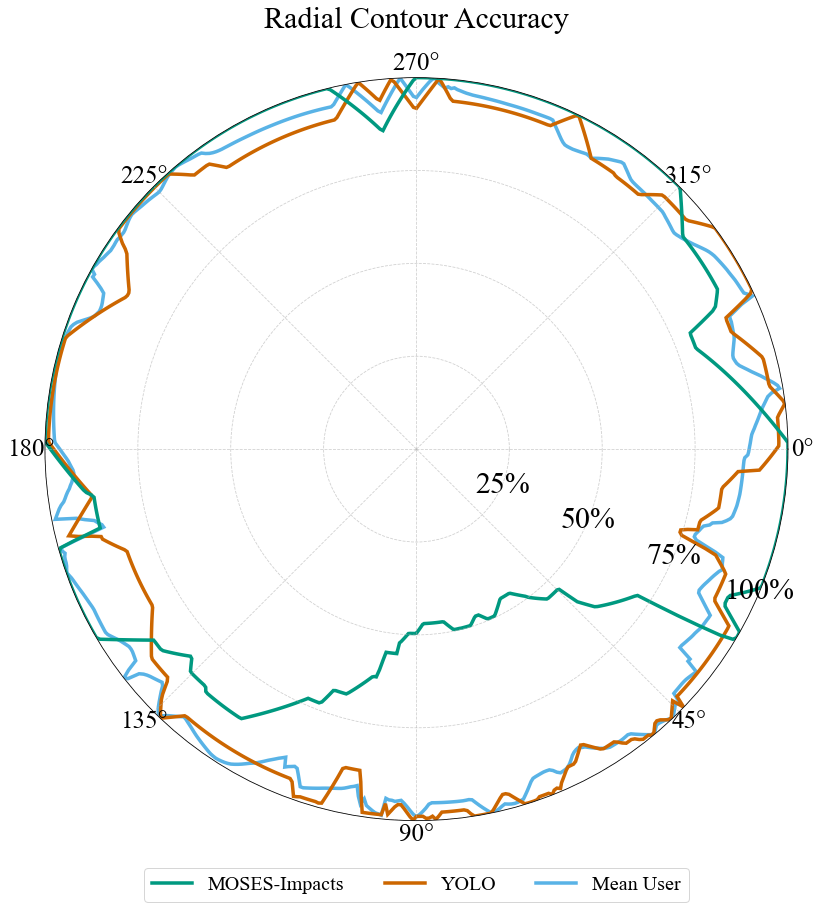

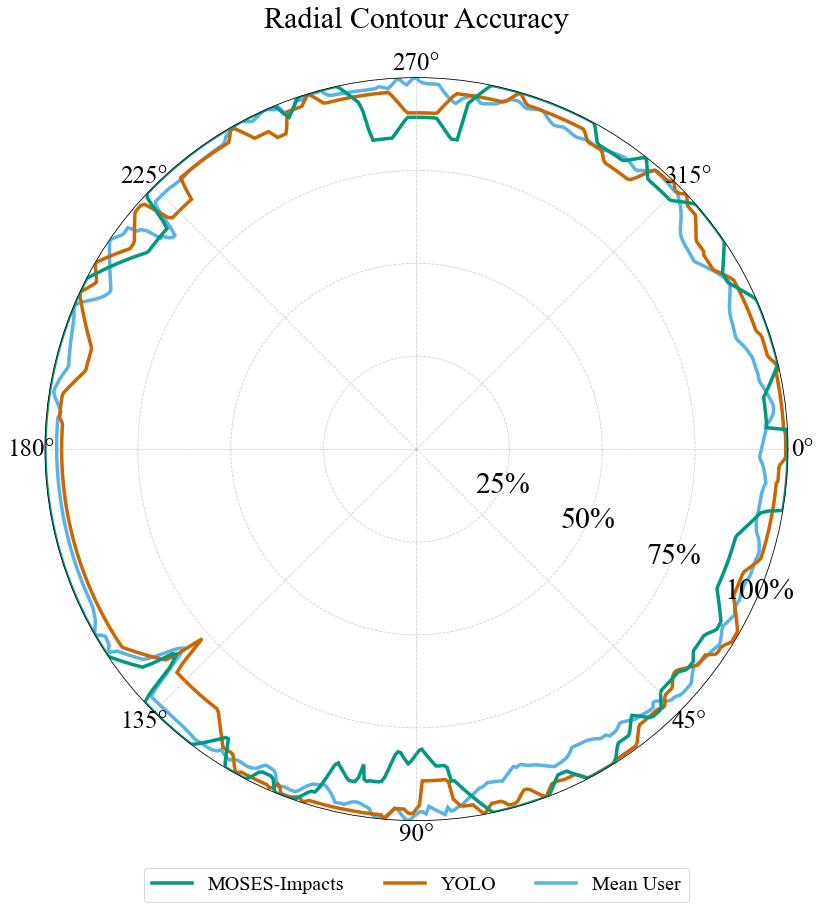

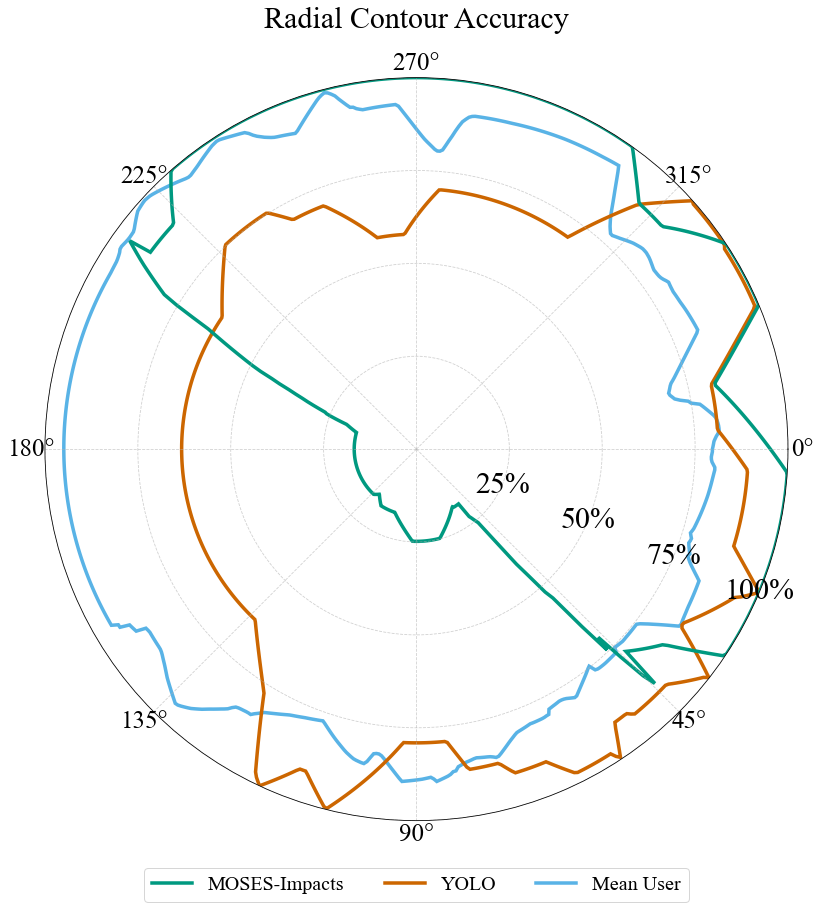

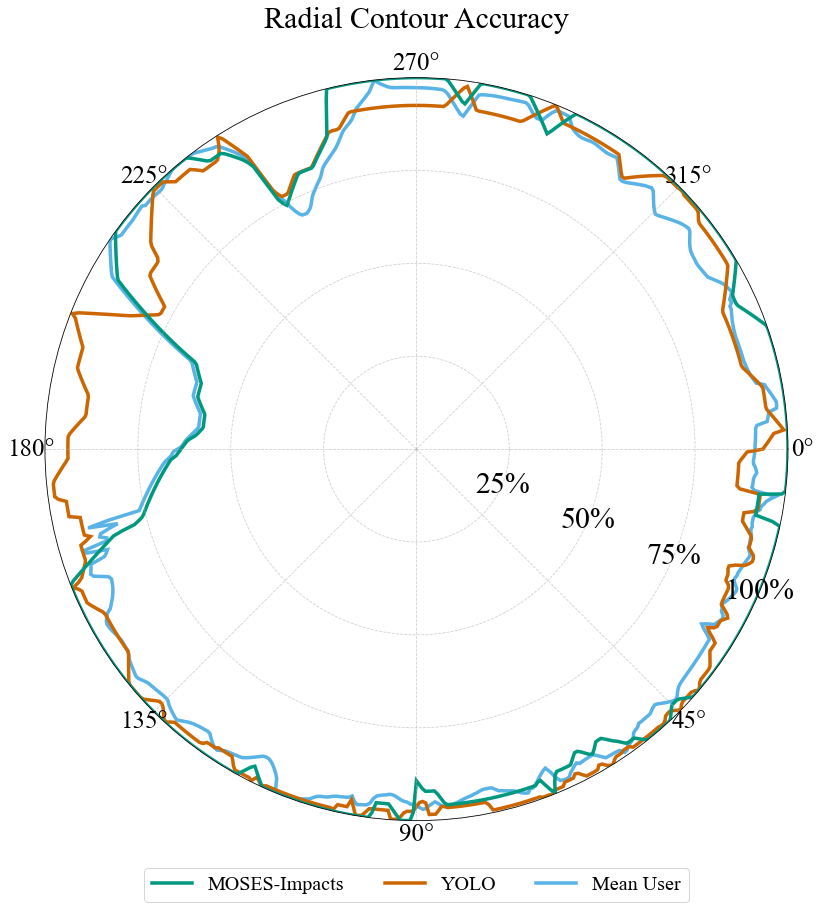

In [24]:
deviations_standaradreference_vs_user_mean=[]
deviations_standaradreference_vs_yolo=[]
deviations_standaradreference_vs_algo=[]

for i in range(0,len(all_standardreference_radii)):
    name = image_paths[i].replace('\\', '/').split('/')[-1].split('.')[-2]
    standardreference_radii=all_standardreference_radii[i][0]
    user_mean_radii = []
    for part in bands[i][1]:
        user_mean_radii.extend(part)
    plt.rcParams["figure.figsize"] = (12, 12)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},facecolor='white')
    #for radii_mean_user in all_compare_radii_mean_users[i]:
    ax.fill(angles, [rc.intersection_deviation(standardreference_radii[a], user_mean_radii[a]) for a in range(len(angles))], fill=False, c=[0.35,0.7,0.9], linewidth=3.5)
    dev=[rc.intersection_deviation(standardreference_radii[a], user_mean_radii[a]) for a in range(len(angles))]
    deviations_standaradreference_vs_user_mean.append(dev)
    for radii_yolo in all_compare_radii_yolo[i]:
        ax.fill(angles, [rc.intersection_deviation(standardreference_radii[a], radii_yolo[a]) for a in range(len(angles))], fill=False, c=[0.8, 0.4, 0], linewidth=3.50)
        dev_1=[rc.intersection_deviation(standardreference_radii[a], radii_yolo[a]) for a in range(len(angles))]
    deviations_standaradreference_vs_yolo.append(dev_1)
    for radii_algo in all_compare_radii_algo[i]:
        ax.fill(angles, [rc.intersection_deviation(standardreference_radii[a], radii_algo[a]) for a in range(len(angles))], fill=False, c=[0, 0.6, 0.5], linewidth=3.5) 
        dev_2=[rc.intersection_deviation(standardreference_radii[a], radii_algo[a]) for a in range(len(angles))]
        deviations_standaradreference_vs_algo.append(dev_2)
    #ax.set_rmax(1.1)
    ax.set_xticks([0, np.pi/4, np.pi/2, np.pi*3/4, np.pi, np.pi*5/4, np.pi*3/2, np.pi*7/4])
    ax.set_xticklabels(["0°", "45°", "90°", "135°", "180°", "225°", "270°", "315°"],fontsize=25, fontname="Times New Roman")
    #ax.set_xticklabels([])
    #ax.set_rticks([0.5, 1])
    ax.set_rmax(1.0)  # Skala bleibt zwischen 0 und 1 (100%)
    ax.set_rticks([0.25, 0.5, 0.75, 1.0])  # Markierungen für 25%, 50%, 75%, 100%
    ax.set_yticklabels(["25%", "50%", "75%", "100%"], fontsize=30, fontname="Times New Roman",va="center", ha="center")
    #ax.set_yticklabels([])
    ax.set_theta_direction(-1)
    ax.grid(True,linestyle="--", alpha=0.6)
    plt.title("Radial Contour Accuracy", fontsize=30, fontname="Times New Roman", pad=50)

    legend_elements = [Line2D([0], [0], color=[0, 0.6, 0.5], lw=3.5, label='MOSES-Impacts'), Line2D([0], [0], color=[0.8, 0.4, 0], lw=3.5, label='YOLO'),
        Line2D([0], [0], color=[0.35,0.7,0.9], lw=3.5, label='Mean User')]
    ax.legend(handles=legend_elements,
        loc='upper center',  # Legende oben mittig
        bbox_to_anchor=(0.5, -0.05),  # Platzierung unterhalb des Plots
        ncol=3,  # Elemente in einer Reihe anordnen
        frameon=True,
        prop={'family': 'Times New Roman', 'size': 20}  # Schriftart setzen
        )
  
    plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.91, wspace=0.01, hspace=0.01)
    plt.savefig(f"{savepath}/{name}_pol.png", bbox_inches='tight')
    #plt.close()

mean_deviations_standaradreference_vs_user_mean=[]
mean_deviations_standaradreference_vs_yolo=[]
mean_deviations_standaradreference_vs_algo=[]

std_deviations_standaradreference_vs_user_mean=[]
std_deviations_standaradreference_vs_yolo=[]
std_deviations_standaradreference_vs_algo=[]

mean_deviations_standaradreference_vs_user_mean= [np.mean(deviations_standaradreference_vs_user_mean[i]) for i in range(len(standardreference_polygons))]
mean_deviations_standaradreference_vs_yolo= [np.mean(deviations_standaradreference_vs_yolo[i]) for i in range(len(standardreference_polygons))]
mean_deviations_standaradreference_vs_algo= [np.mean(deviations_standaradreference_vs_algo[i]) for i in range(len(standardreference_polygons))]

std_deviations_standaradreference_vs_user_mean= [np.std(deviations_standaradreference_vs_user_mean[i]) for i in range(len(standardreference_polygons))]
std_deviations_standaradreference_vs_yolo= [np.std(deviations_standaradreference_vs_yolo[i]) for i in range(len(standardreference_polygons))]
std_deviations_standaradreference_vs_algo= [np.std(deviations_standaradreference_vs_algo[i]) for i in range(len(standardreference_polygons))]

print("Mean deviations and std per image:")
for i in range(len(standardreference_polygons)):
    print(f"Image {i}:")
    print(f"  MOSES         : {mean_deviations_standaradreference_vs_algo[i]*100:.4f} % std: {std_deviations_standaradreference_vs_algo[i]*100:.4f} %")
    print(f"  YOLO          : {mean_deviations_standaradreference_vs_yolo[i]*100:.4f} % std: {std_deviations_standaradreference_vs_yolo[i]*100:.4f} %")
    print(f"  User Mean     : {mean_deviations_standaradreference_vs_user_mean[i]*100:.4f} % std: {std_deviations_standaradreference_vs_user_mean[i]*100:.4f} %")


#Standardabweichung über alle Winkel, aller Bilder
std_all_deviations_standaradreference_vs_user_mean=np.std(np.array(deviations_standaradreference_vs_user_mean).flatten())
std_all_deviations_standaradreference_vs_yolo=np.std(np.array(deviations_standaradreference_vs_yolo).flatten())
std_all_deviations_standaradreference_vs_algo=np.std(np.array(deviations_standaradreference_vs_algo).flatten())

# Gesamtmittelwerte
print("\nOverall mean deviations:")
print(f"MOSES         : {np.mean(mean_deviations_standaradreference_vs_algo)*100:.4f} % std: {std_all_deviations_standaradreference_vs_algo*100:.4f} %")
print(f"YOLO          : {np.mean(mean_deviations_standaradreference_vs_yolo)*100:.4} % std: {std_all_deviations_standaradreference_vs_yolo*100:.4f} %")
print(f"User Mean     : {np.mean(mean_deviations_standaradreference_vs_user_mean)*100:.4f} % std: {std_all_deviations_standaradreference_vs_user_mean*100:.4f} %")

# AREA COMPARISON:

In [25]:
def IoU_poly_2(ref_poly, other_poly):    
    iou_polys = []
    for i in range(len(ref_poly)):       
        if not ref_poly[i] or not other_poly[i]:  # Prüft, ob Listen leer sind
            print(f"⚠️ Keine Polygone für Datei {i} gefunden, IoU = 0")
            iou_polys.append(0)
            continue

        try:
            ref_poly_1 = ref_poly[i][0]  # Erstes Polygon aus der Liste nehmen
            other_poly_1 = other_poly[i][0]  # Erstes Polygon aus der Liste nehmen
            
            # Berechne Schnitt- und Vereinigungsfläche
            intersection_area = ref_poly_1.intersection(other_poly_1).area
            union_area = ref_poly_1.union(other_poly_1).area

            # IoU berechnen, wobei Division durch 0 vermieden wird
            iou_poly = intersection_area / union_area if union_area > 0 else 0  
            iou_poly = round(iou_poly, 2)

        except Exception as e:
            print(f"❌ Fehler bei IoU-Berechnung für Datei {i}: {e}")
            iou_poly = 0

        iou_polys.append(iou_poly)

    return iou_polys


In [40]:
all_compare_masks_mean_users = [] 

for image_path in image_paths:
    name = image_path.replace('\\', '/').split('/')[-1].split('.')[-2]
    compare_masks_paths_mean_users = glob.glob(savepath + '/' + name + '_mean_user_contour_yolo_Koordinaten' + '.txt')
    compare_masks_paths_mean_users.sort()
    all_compare_masks_mean_users.append(gf.read_masks_from_txt(compare_masks_paths_mean_users)[1])

mean_user_polygons = [gf.polygons_from_coordinates([mask[0] if mask != [] else mask for mask in masks])[0] for masks in all_compare_masks_mean_users]

IoUs_ref_algo= IoU_poly_2(standardreference_polygons,compare_polygons_algo)
print("→ IoU (MOSES vs Ref):")
print(IoUs_ref_algo)
print(" ")
IoUs_ref_yolo= IoU_poly_2(standardreference_polygons,compare_polygons_yolo)
print("→ IoU (Yolo vs Ref):")
print(IoUs_ref_yolo)
print(" ")
IoUs_ref_mean_user= IoU_poly_2(standardreference_polygons,mean_user_polygons)
print("→ IoU (Mean User vs Ref):")
print(IoUs_ref_mean_user)
print(" ")
print(f"→ Mean IoU (MOSES vs Ref): {np.mean(IoUs_ref_algo):.3f}")
print(f"  STD IoU (MOSES vs Ref): {np.std(IoUs_ref_algo):.3f}")
print(" ")
print(f"→ Mean IoU (YOLO vs Ref): {np.mean(IoUs_ref_yolo):.3f}")
print(f"  STD IoU (YOLO vs Ref): {np.std(IoUs_ref_yolo):.3f}")
print(" ")
print(f"→ Mean IoU (Mean User vs Ref): {np.mean(IoUs_ref_mean_user):.3f}")
print(f"  STD IoU (Mean User vs Ref): {np.std(IoUs_ref_mean_user):.3f}")

→ IoU (MOSES vs Ref):
[0.89, 0.56, 0.9, 0.07, 0.89]
 
→ IoU (Yolo vs Ref):
[0.88, 0.9, 0.92, 0.65, 0.91]
 
→ IoU (Mean User vs Ref):
[0.88, 0.9, 0.93, 0.76, 0.52]
 
→ Mean IoU (MOSES vs Ref): 0.662
  STD IoU (MOSES vs Ref): 0.323
 
→ Mean IoU (YOLO vs Ref): 0.852
  STD IoU (YOLO vs Ref): 0.102
 
→ Mean IoU (Mean User vs Ref): 0.798
  STD IoU (Mean User vs Ref): 0.151
